<h2>Rice Plant Diseases Dataset을 사용한 모델 성능 비교<h2>

### 라이브러리 정리

In [ ]:
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib.image import imread
import glob

from collections import defaultdict, Counter

In [ ]:
# !pip install grad-cam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# 모델 결과 저장을 위해 Google Drive 마운트
from google.colab import drive
import sqlite3
import os
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/Code/ktb/assignment/8th/model_weights"
grad_cam_dir = "/content/drive/MyDrive/Code/ktb/assignment/8th/grad_cam"
db_path = "/content/drive/MyDrive/Code/ktb/assignment/8th/experiment_logs.db"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Mounted at /content/drive


### DB 준비

In [ ]:
# DB 초기화: experiment_log 테이블 생성 (최초 1회 실행)
"""
conn = sqlite3.connect(db_path)
c = conn.cursor()
c.execute('''
CREATE TABLE IF NOT EXISTS experiment_log (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT NOT NULL,
    model_name TEXT,
    tuning_type TEXT,
    data_type TEXT,
    version TEXT,
    epochs INTEGER,
    train_time_sec REAL,
    test_loss REAL,
    test_acc REAL,
    pth_path TEXT,
    grad_cam_path TEXT,
    note TEXT
)
''')
conn.commit()
conn.close()
"""
pass

### 데이터셋 다운로드 및 확인

In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import files
files.upload()  # 'kaggle.json' 파일 업로드

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Orange Diseases 데이터셋 다운로드
!kaggle datasets download -d jay7080dev/rice-plant-diseases-dataset

# 압축 해제
!unzip /content/rice-plant-diseases-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jay7080dev/rice-plant-diseases-dataset
License(s): apache-2.0
Archive:  /content/rice-plant-diseases-dataset.zip
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_001.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_002.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_003.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_004.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_005.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_006.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_007.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_008.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_009.jpg  
  inflating: rice leaf diseases dataset/Bacterialblight/BACTE

In [ ]:
def print_dataset_stats(dataset_path):
    """
    주어진 dataset_path 내의 각 클래스 폴더에 대해
      - 클래스별 이미지 개수
      - 파일 확장자 분포
      - 이미지 해상도 (평균, 최소, 최대)
      - 이미지 타입(mode) 분포
    를 출력합니다.
    """
    class_counts = defaultdict(int)
    file_types = Counter()
    img_sizes = []
    img_modes = Counter()

    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            files = os.listdir(class_folder)
            class_counts[class_name] = len(files)
            for file in files:
                ext = os.path.splitext(file)[-1].lower()
                file_types[ext] += 1
                img_path = os.path.join(class_folder, file)
                try:
                    with Image.open(img_path) as img:
                        img_sizes.append(img.size)
                        img_modes[img.mode] += 1
                except Exception as e:
                    print(f"Error opening {img_path}: {e}")

    print("=== 클래스별 이미지 개수 ===")
    for cls, cnt in class_counts.items():
        print(f"{cls}: {cnt} images")

    print("\n=== 파일 포맷 분포 ===")
    for ext, cnt in file_types.items():
        print(f"{ext}: {cnt} files")

    if img_sizes:
        widths, heights = zip(*img_sizes)
        print("\n=== 이미지 해상도 통계 ===")
        print(f"평균: {sum(widths)//len(widths)} x {sum(heights)//len(heights)}")
        print(f"최소: {min(widths)} x {min(heights)}")
        print(f"최대: {max(widths)} x {max(heights)}")

    print("\n=== 이미지 타입 분포 ===")
    for mode, count in img_modes.items():
        print(f"{mode}: {count} images")

    return class_counts.items()


# 이미지 상태 확인
dataset_dict = print_dataset_stats('/content/rice leaf diseases dataset')

=== 클래스별 이미지 개수 ===
Bacterialblight: 1604 images
Leafsmut: 1460 images
Brownspot: 1620 images

=== 파일 포맷 분포 ===
.jpg: 4684 files

=== 이미지 해상도 통계 ===
평균: 300 x 300
최소: 300 x 300
최대: 300 x 300

=== 이미지 타입 분포 ===
RGB: 4520 images
RGBA: 164 images


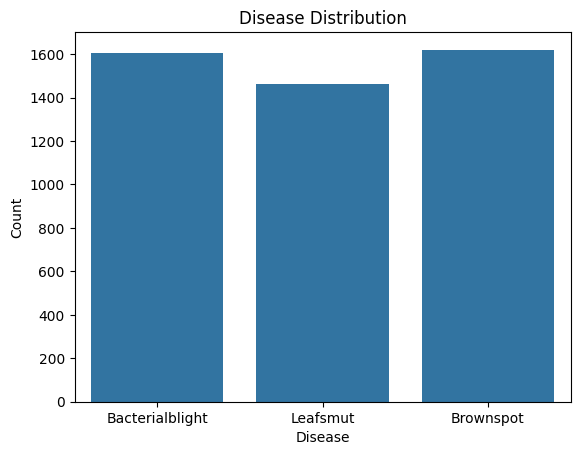

In [ ]:
# 이미지 개수 시각화
df = pd.DataFrame(list(dataset_dict), columns=['Disease', 'Count'])

sns.barplot(data=df, x='Disease', y='Count')

plt.title('Disease Distribution')
plt.xlabel('Disease')
plt.ylabel('Count')

plt.show()

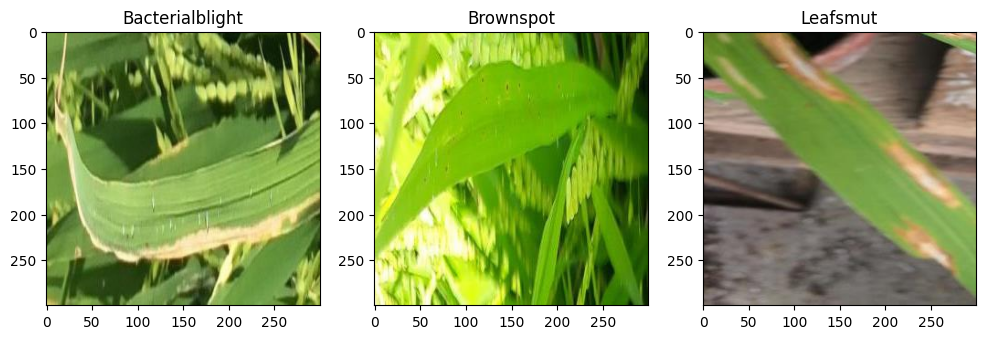

In [ ]:
# 이미지 1장씩 출력
bb_path = glob.glob('/content/rice leaf diseases dataset/Bacterialblight/*')
bs_path = glob.glob('/content/rice leaf diseases dataset/Brownspot/*')
lm_path = glob.glob('/content/rice leaf diseases dataset/Leafsmut/*')

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(imread(bb_path[0]))
ax[1].imshow(imread(bs_path[0]))
ax[2].imshow(imread(lm_path[0]))
ax[0].set_title('Bacterialblight')
ax[1].set_title('Brownspot')
ax[2].set_title('Leafsmut')

plt.show()

### 데이터셋 전처리

In [ ]:
full_dataset = ImageFolder(root='/content/rice leaf diseases dataset/')

train_size = int(0.8 * len(full_dataset))
valid_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

train_subset, valid_subset, test_subset = random_split(full_dataset, [train_size, valid_size, test_size])

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 다양하게 crop
    transforms.RandomHorizontalFlip(),  # 좌우 플립
    transforms.RandomRotation(30),       # 30도 범위 내 회전
    # 색상 변형을 최소화: 살짝 어둡게(밝기 약간 낮춤), 대비 약간 변경, 채도/색조 변화 없음
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

plain_transform = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
def denormalize(tensor, mean, std):
    """
    Normalize된 tensor를 원래대로 되돌립니다.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def show_augmented_images(dataset, num_images=10, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    augmentation transform이 적용된 데이터셋에서 이미지 몇 개를 확인합니다.
    2줄 x 5개 레이아웃으로 보여줍니다.
    """
    rows = 2
    cols = num_images // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image, label = dataset[i]
        # de-normalize 수행
        image = denormalize(image, mean, std)
        # numpy로 변환
        npimg = image.cpu().numpy().transpose((1, 2, 0))
        # imshow 범위 클리핑
        npimg = np.clip(npimg, 0, 1)
        axes[i].imshow(npimg)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.suptitle("Augmented Images Sample", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# train: 증강 O
train_aug_dataset = CustomDataset(train_subset, transform=train_transform)

# train: 증강 X (baseline)
train_plain_dataset = CustomDataset(train_subset, transform=plain_transform)

# valid & test는 전처리만
valid_dataset = CustomDataset(valid_subset, transform=plain_transform)
test_dataset = CustomDataset(test_subset, transform=plain_transform)

In [ ]:
train_aug_loader = DataLoader(train_aug_dataset, batch_size=32, shuffle=True)
train_plain_loader = DataLoader(train_plain_dataset, batch_size=32, shuffle=True)

# 고정
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

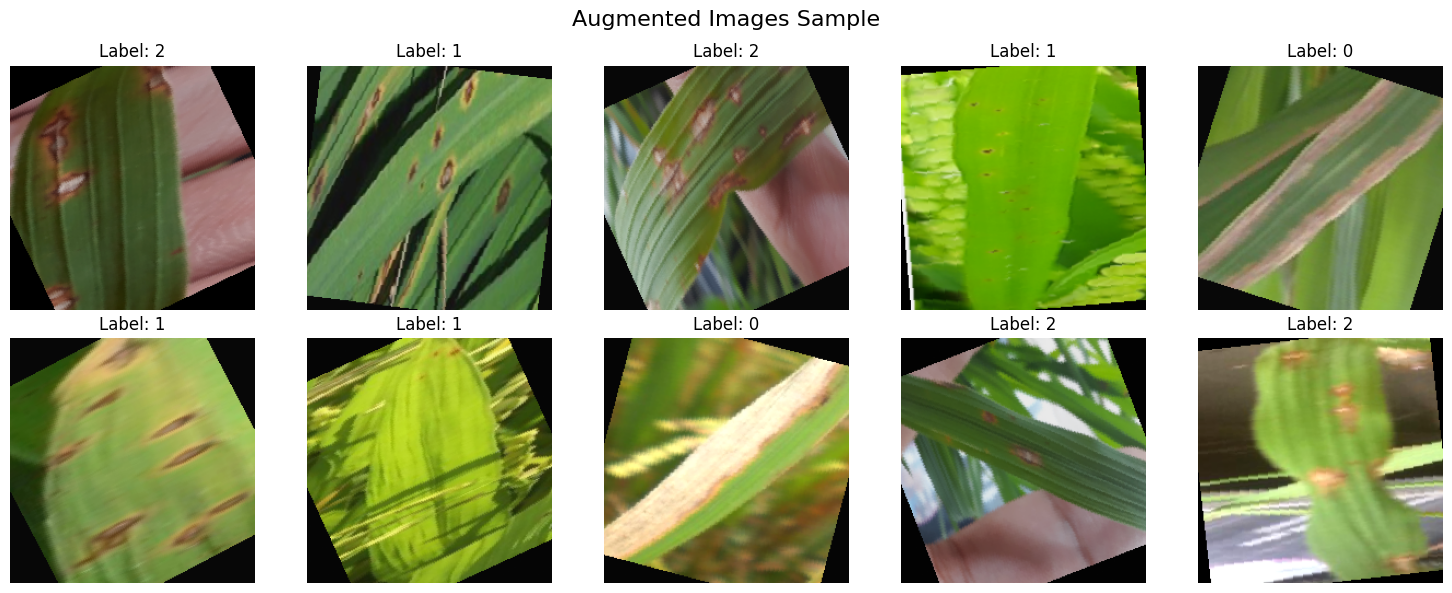

In [ ]:
show_augmented_images(train_aug_dataset)

### 모델 학습 준비

- 대형 모델 : ResNet-50
- 중형 모델 : EfficientNet-B0
- 경량 모델 : MobileNetV2

#### 모델 준비

In [ ]:
import math
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

def get_model(name="resnet50", num_classes=3, mode="feature_extract"):
    if name == "resnet50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if mode == "baseline":
            optimizer = None
        elif mode == "feature_extract":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        elif mode == "partial_finetuning":
            # 기본적으로 모든 파라미터를 freeze
            for param in model.parameters():
                param.requires_grad = False
            # 백본의 4개 레이어 중 마지막 layer4만 unfreeze
            for param in model.layer4.parameters():
                param.requires_grad = True
            # fc 레이어도 학습 대상
            for param in model.fc.parameters():
                param.requires_grad = True
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.Adam(params, lr=1e-4)
        elif mode == "full_finetuning":
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
        else:
            raise ValueError("Unknown mode")

    elif name == "efficientnet_b2":
        model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        if mode == "baseline":
            optimizer = None
        elif mode == "feature_extract":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
        elif mode == "partial_finetuning":
            for param in model.parameters():
                param.requires_grad = False
            # model.features는 여러 블록의 Sequential 컨테이너이므로, 전체 블록 수의 약 1/4만 unfreeze
            num_blocks = len(model.features)
            num_to_unfreeze = math.ceil(num_blocks / 4)
            print("\EfficientNet-B2 Unfreeze num : " + str(num_to_unfreeze))
            for i in range(num_blocks - num_to_unfreeze, num_blocks):
                for param in model.features[i].parameters():
                    param.requires_grad = True
            # classifier 부분도 학습 대상으로 포함
            for param in model.classifier.parameters():
                param.requires_grad = True
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.Adam(params, lr=1e-4)
        elif mode == "full_finetuning":
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
        else:
            raise ValueError("Unknown mode")

    elif name == "mobilenet_v2":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        if mode == "baseline":
            optimizer = None
        elif mode == "feature_extract":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
        elif mode == "partial_finetuning":
            for param in model.parameters():
                param.requires_grad = False
            # model.features의 전체 블록 중 마지막 1/4만 unfreeze
            num_blocks = len(model.features)
            num_to_unfreeze = math.ceil(num_blocks / 4)
            print("\tMobileNetv2 Unfreeze num : " + str(num_to_unfreeze))
            for i in range(num_blocks - num_to_unfreeze, num_blocks):
                for param in model.features[i].parameters():
                    param.requires_grad = True
            # classifier도 unfreeze
            for param in model.classifier.parameters():
                param.requires_grad = True
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.Adam(params, lr=1e-4)
        elif mode == "full_finetuning":
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
        else:
            raise ValueError("Unknown mode")

    else:
        raise ValueError("Unknown model name")

    model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    return model, optimizer


In [ ]:
model_names = ["resnet50", "efficientnet_b2", "mobilenet_v2"]
tuning_modes = ["feature_extract", "partial_finetuning", "full_finetuning"]
data_versions = ["plain", "aug"]

# 저장할 곳
models_dict = {}

for model_name in model_names:
    for tuning_mode in tuning_modes:
        for data_version in data_versions:
            key = f"{model_name}-{tuning_mode}-{data_version}"
            model, optimizer = get_model(name=model_name, num_classes=3, mode=tuning_mode)
            models_dict[key] = (model, optimizer)
            print(f"Prepared {key}")

# 예시: models_dict["resnet50-feature_extract-plain"]에 해당 모델과 옵티마이저가 저장됩니다.

Prepared resnet50-feature_extract-plain
Prepared resnet50-feature_extract-aug
Prepared resnet50-partial_finetuning-plain
Prepared resnet50-partial_finetuning-aug
Prepared resnet50-full_finetuning-plain
Prepared resnet50-full_finetuning-aug
Prepared efficientnet_b2-feature_extract-plain
Prepared efficientnet_b2-feature_extract-aug
\EfficientNet-B2 Unfreeze num : 3
Prepared efficientnet_b2-partial_finetuning-plain
\EfficientNet-B2 Unfreeze num : 3
Prepared efficientnet_b2-partial_finetuning-aug
Prepared efficientnet_b2-full_finetuning-plain
Prepared efficientnet_b2-full_finetuning-aug
Prepared mobilenet_v2-feature_extract-plain
Prepared mobilenet_v2-feature_extract-aug
	MobileNetv2 Unfreeze num : 5
Prepared mobilenet_v2-partial_finetuning-plain
	MobileNetv2 Unfreeze num : 5
Prepared mobilenet_v2-partial_finetuning-aug
Prepared mobilenet_v2-full_finetuning-plain
Prepared mobilenet_v2-full_finetuning-aug


#### 학습 및 검증, 테스트 함수

In [ ]:
FE_NUM_EPOCHS = 20
PT_NUM_EPOCHS = 10
FT_NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def test_model(model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # 전역 test_loader 사용
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_acc = correct / total
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")
    return test_loss, test_acc, all_preds, all_labels

In [ ]:
def show_confusion_matrix(all_preds, all_labels):
    # Confusion Matrix 계산
    cm = confusion_matrix(all_labels, all_preds)

    # Seaborn을 이용한 Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_validate(model, train_loader, valid_loader, optimizer, loss_fn, epochs, model_name, tuning_type, data_type, version):
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        # TRAIN
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        # VALID
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] train_loss: {train_loss:.4f} | train_acc: {train_acc*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

    # 모델 저장
    model_pth = f"{save_dir}/{model_name}-{tuning_type}-{data_type}-{version}.pth"
    torch.save(model.state_dict(), model_pth)

    return results

In [ ]:
def plot_training_results(results):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["val_loss"], label="Valid Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["val_acc"], label="Valid Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import time
from datetime import datetime

def run_experiment(model, train_loader, valid_loader, optimizer, loss_fn, epochs, model_name, tuning_type, data_type, version, desc, note=""):
    print(f"===== Training {desc} =====")
    start_time = time.time()

    results = train_and_validate(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        model_name=model_name,
        tuning_type=tuning_type,
        data_type=data_type,
        version=version
    )
    train_time_sec = time.time() - start_time
    plot_training_results(results)

    print(f"\n===== {desc} Test =====")
    test_loss, test_acc, all_preds, all_labels = test_model(model, loss_fn)

    save_result(model_name, tuning_type, data_type, version, epochs, train_time_sec, test_loss, test_acc, note="")



In [ ]:
def save_result(model_name, tuning_type, data_type, version, epochs, train_time_sec, test_loss, test_acc, note=""):
    # 파일 경로
    pth_path = f"{save_dir}/{model_name}-{tuning_type}-{data_type}-{version}.pth"
    grad_cam_path = f"{grad_cam_dir}/{model_name}-{tuning_type}-{data_type}-{version}.png"

    # DB에 간단한 로그 저장
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    c.execute("""
    INSERT INTO experiment_log (
        timestamp, model_name, tuning_type, data_type, version, epochs, train_time_sec, test_loss, test_acc, pth_path, grad_cam_path, note
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        timestamp, model_name, tuning_type, data_type, version, epochs, train_time_sec, test_loss, test_acc, pth_path, grad_cam_path, note
    ))
    conn.commit()
    conn.close()

    print("Experiment log saved to DB.")

### Baseline 확인


Test Loss: 1.1066, Test Accuracy: 33.26%
Retest 결과 - Test Loss: 1.1066, Test Accuracy: 33.26%


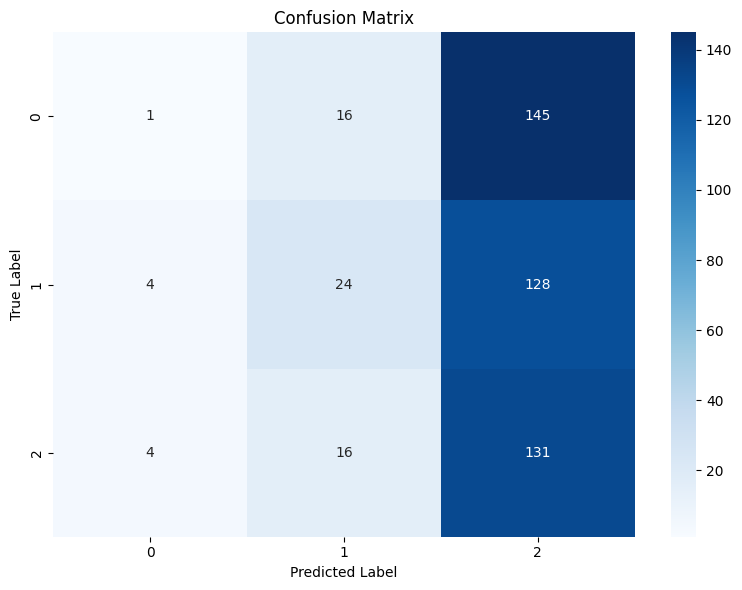





Test Loss: 1.1052, Test Accuracy: 31.13%
Retest 결과 - Test Loss: 1.1052, Test Accuracy: 31.13%


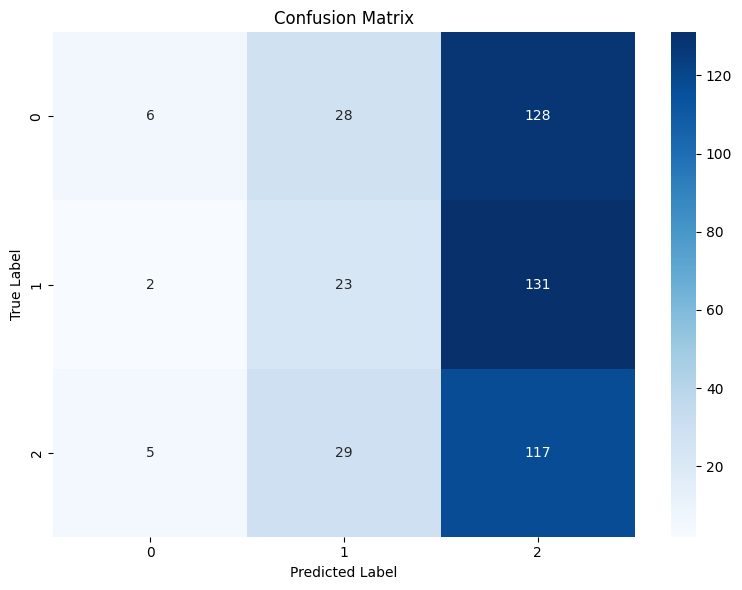





Test Loss: 1.1225, Test Accuracy: 27.29%
Retest 결과 - Test Loss: 1.1225, Test Accuracy: 27.29%


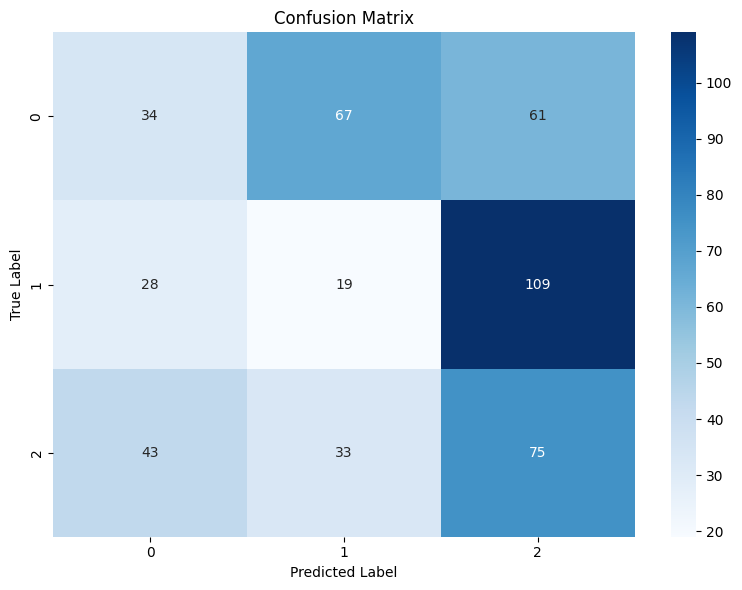

In [ ]:
targets = [
    ("resnet50", "baseline"),
    ("efficientnet_b2", "baseline"),
    ("mobilenet_v2", "baseline")
]

# 모델 로드
for target_model_name, target_tuning_type,  in targets:
    model, _ = get_model(
        name=target_model_name,
        num_classes=3,
        mode=target_tuning_type)
    model.to(device)

    test_loss, test_acc, all_preds, all_labels = test_model(model, loss_fn)
    print(f"Retest 결과 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

    show_confusion_matrix(all_preds, all_labels)
    print('\n\n')

### 그룹 별 학습

#### Feature Extract - Plain

===== Training resnet50-feature_extract-PLAIN =====
Epoch [1/20] train_loss: 0.5110 | train_acc: 83.56% | val_loss: 0.2834 | val_acc: 93.38%
Epoch [2/20] train_loss: 0.2492 | train_acc: 94.00% | val_loss: 0.1938 | val_acc: 96.58%
Epoch [3/20] train_loss: 0.1614 | train_acc: 97.04% | val_loss: 0.1368 | val_acc: 97.65%
Epoch [4/20] train_loss: 0.1280 | train_acc: 97.62% | val_loss: 0.0986 | val_acc: 99.36%
Epoch [5/20] train_loss: 0.1060 | train_acc: 98.69% | val_loss: 0.0836 | val_acc: 99.79%
Epoch [6/20] train_loss: 0.0907 | train_acc: 98.32% | val_loss: 0.0598 | val_acc: 99.57%
Epoch [7/20] train_loss: 0.0832 | train_acc: 98.77% | val_loss: 0.0590 | val_acc: 99.79%
Epoch [8/20] train_loss: 0.0684 | train_acc: 99.41% | val_loss: 0.0450 | val_acc: 100.00%
Epoch [9/20] train_loss: 0.0535 | train_acc: 99.49% | val_loss: 0.0442 | val_acc: 100.00%
Epoch [10/20] train_loss: 0.0523 | train_acc: 99.49% | val_loss: 0.0349 | val_acc: 100.00%
Epoch [11/20] train_loss: 0.0447 | train_acc: 99.57% |

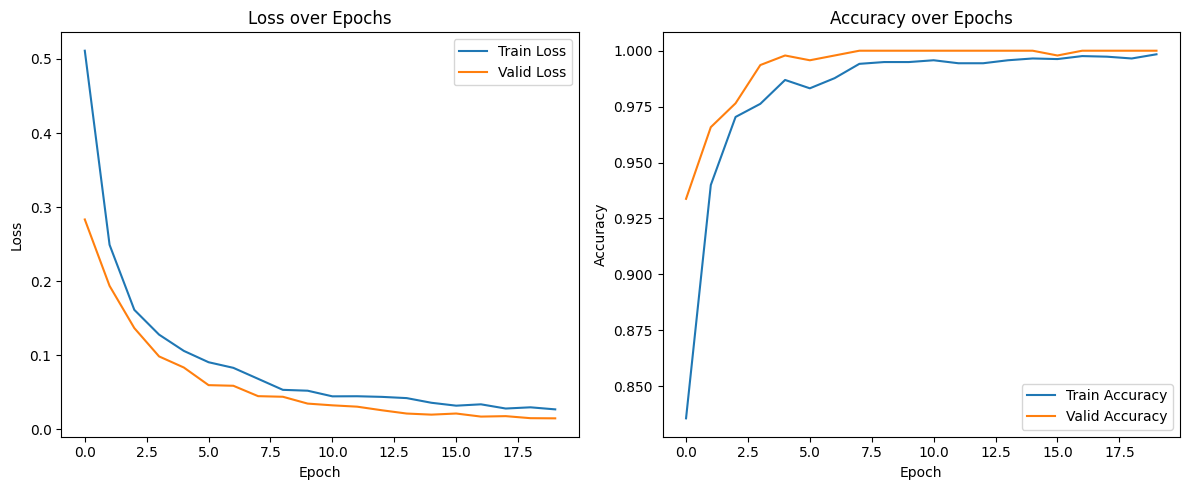


===== resnet50-feature_extract-PLAIN Test =====

Test Loss: 0.0183, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training efficientnet_b2-feature_extract-PLAIN =====
Epoch [1/20] train_loss: 0.5804 | train_acc: 80.41% | val_loss: 0.3501 | val_acc: 90.60%
Epoch [2/20] train_loss: 0.3320 | train_acc: 90.05% | val_loss: 0.2492 | val_acc: 93.16%
Epoch [3/20] train_loss: 0.2637 | train_acc: 91.99% | val_loss: 0.1918 | val_acc: 95.94%
Epoch [4/20] train_loss: 0.2205 | train_acc: 93.30% | val_loss: 0.1668 | val_acc: 97.22%
Epoch [5/20] train_loss: 0.1960 | train_acc: 93.78% | val_loss: 0.1466 | val_acc: 97.65%
Epoch [6/20] train_loss: 0.1762 | train_acc: 95.04% | val_loss: 0.1213 | val_acc: 98.29%
Epoch [7/20] train_loss: 0.1829 | train_acc: 94.21% | val_loss: 0.1116 | val_acc: 97.44%
Epoch [8/20] train_loss: 0.1796 | train_acc: 94.24% | val_loss: 0.0931 | val_acc: 98.50%
Epoch [9/20] train_loss: 0.1554 | train_acc: 95.14% | val_loss: 0.0977 | val_acc: 98.29%
Epoch [10/20] train_

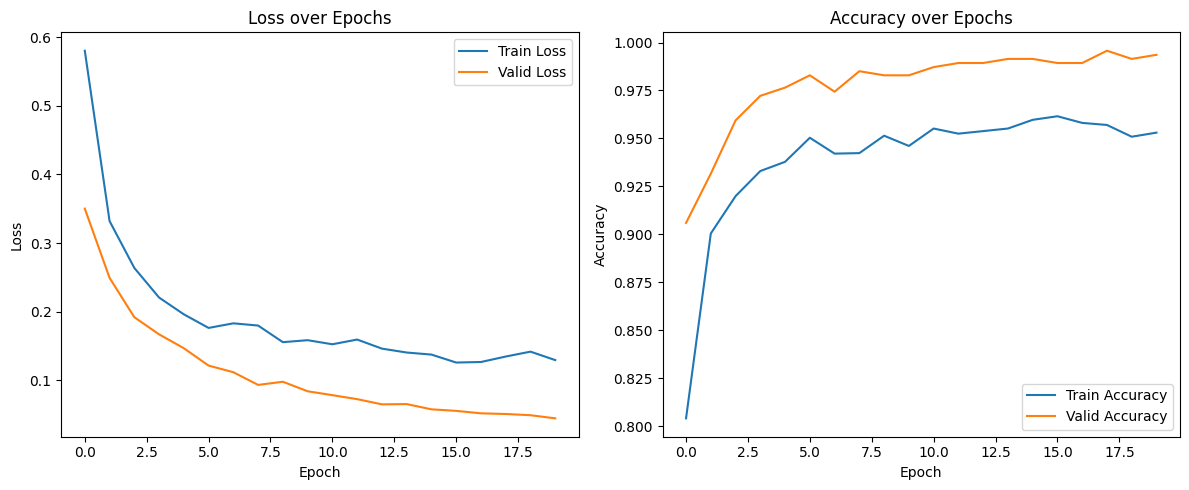


===== efficientnet_b2-feature_extract-PLAIN Test =====

Test Loss: 0.0535, Test Accuracy: 99.15%
Experiment log saved to DB.
===== Training mobilenet_v2-feature_extract-PLAIN =====
Epoch [1/20] train_loss: 0.5660 | train_acc: 79.13% | val_loss: 0.3291 | val_acc: 90.81%
Epoch [2/20] train_loss: 0.3236 | train_acc: 90.23% | val_loss: 0.2421 | val_acc: 94.02%
Epoch [3/20] train_loss: 0.2464 | train_acc: 92.61% | val_loss: 0.1946 | val_acc: 95.30%
Epoch [4/20] train_loss: 0.2128 | train_acc: 93.84% | val_loss: 0.1687 | val_acc: 94.66%
Epoch [5/20] train_loss: 0.1818 | train_acc: 95.06% | val_loss: 0.1376 | val_acc: 95.94%
Epoch [6/20] train_loss: 0.1693 | train_acc: 94.96% | val_loss: 0.1276 | val_acc: 97.44%
Epoch [7/20] train_loss: 0.1513 | train_acc: 95.70% | val_loss: 0.1110 | val_acc: 97.44%
Epoch [8/20] train_loss: 0.1493 | train_acc: 96.32% | val_loss: 0.1035 | val_acc: 97.44%
Epoch [9/20] train_loss: 0.1436 | train_acc: 96.45% | val_loss: 0.0913 | val_acc: 98.08%
Epoch [10/20] tra

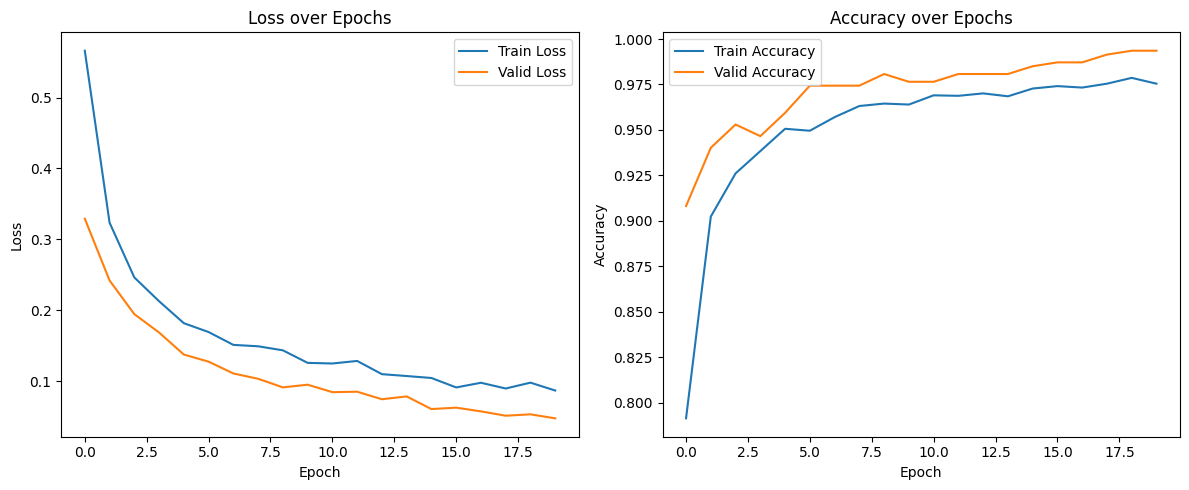


===== mobilenet_v2-feature_extract-PLAIN Test =====

Test Loss: 0.0389, Test Accuracy: 99.36%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "feature_extract"
    target_data_version = "plain"
    target_loader = train_plain_loader
    target_version = "002"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Feature Extract - Plain dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=FE_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


#### Partial FineTuning - Plain

===== Training resnet50-partial_finetuning-PLAIN =====
Epoch [1/10] train_loss: 0.3333 | train_acc: 90.93% | val_loss: 0.0367 | val_acc: 99.36%
Epoch [2/10] train_loss: 0.0215 | train_acc: 99.57% | val_loss: 0.0059 | val_acc: 100.00%
Epoch [3/10] train_loss: 0.0169 | train_acc: 99.81% | val_loss: 0.0021 | val_acc: 100.00%
Epoch [4/10] train_loss: 0.0089 | train_acc: 99.89% | val_loss: 0.0008 | val_acc: 100.00%
Epoch [5/10] train_loss: 0.0194 | train_acc: 99.89% | val_loss: 0.0005 | val_acc: 100.00%
Epoch [6/10] train_loss: 0.0154 | train_acc: 99.84% | val_loss: 0.0011 | val_acc: 100.00%
Epoch [7/10] train_loss: 0.0121 | train_acc: 99.87% | val_loss: 0.0014 | val_acc: 100.00%
Epoch [8/10] train_loss: 0.0053 | train_acc: 99.92% | val_loss: 0.0008 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0063 | train_acc: 99.87% | val_loss: 0.0006 | val_acc: 100.00%
Epoch [10/10] train_loss: 0.0019 | train_acc: 99.97% | val_loss: 0.0003 | val_acc: 100.00%


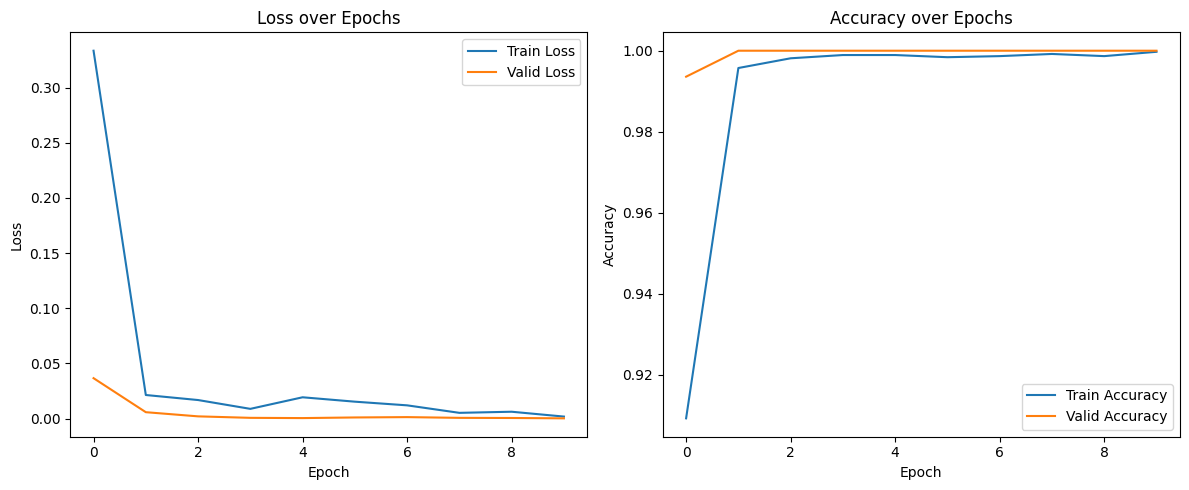


===== resnet50-partial_finetuning-PLAIN Test =====

Test Loss: 0.0006, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training efficientnet_b2-partial_finetuning-PLAIN =====
Epoch [1/10] train_loss: 0.3816 | train_acc: 89.00% | val_loss: 0.0392 | val_acc: 99.79%
Epoch [2/10] train_loss: 0.0438 | train_acc: 99.57% | val_loss: 0.0090 | val_acc: 99.79%
Epoch [3/10] train_loss: 0.0184 | train_acc: 99.76% | val_loss: 0.0030 | val_acc: 100.00%
Epoch [4/10] train_loss: 0.0297 | train_acc: 99.87% | val_loss: 0.0021 | val_acc: 100.00%
Epoch [5/10] train_loss: 0.0180 | train_acc: 99.52% | val_loss: 0.0035 | val_acc: 99.79%
Epoch [6/10] train_loss: 0.0059 | train_acc: 99.97% | val_loss: 0.0029 | val_acc: 99.79%
Epoch [7/10] train_loss: 0.0047 | train_acc: 99.92% | val_loss: 0.0023 | val_acc: 99.79%
Epoch [8/10] train_loss: 0.0312 | train_acc: 99.84% | val_loss: 0.0010 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0176 | train_acc: 99.76% | val_loss: 0.0012 | val_acc: 100.00%
Epoch [10/

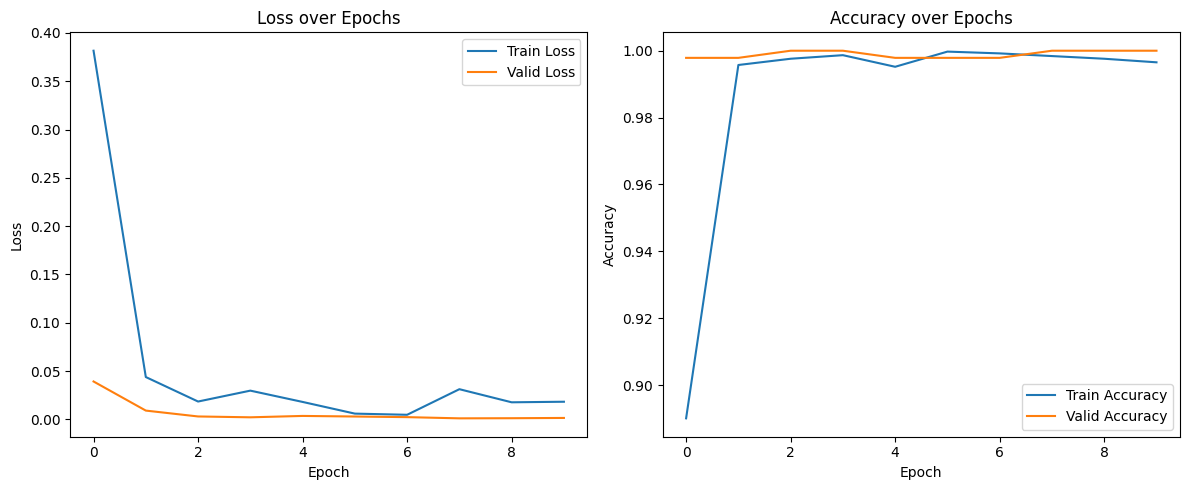


===== efficientnet_b2-partial_finetuning-PLAIN Test =====

Test Loss: 0.0008, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training mobilenet_v2-partial_finetuning-PLAIN =====
Epoch [1/10] train_loss: 0.4918 | train_acc: 85.29% | val_loss: 0.0991 | val_acc: 99.36%
Epoch [2/10] train_loss: 0.0733 | train_acc: 98.88% | val_loss: 0.0160 | val_acc: 100.00%
Epoch [3/10] train_loss: 0.0254 | train_acc: 99.65% | val_loss: 0.0051 | val_acc: 100.00%
Epoch [4/10] train_loss: 0.0163 | train_acc: 99.84% | val_loss: 0.0027 | val_acc: 100.00%
Epoch [5/10] train_loss: 0.0087 | train_acc: 99.89% | val_loss: 0.0014 | val_acc: 100.00%
Epoch [6/10] train_loss: 0.0164 | train_acc: 99.81% | val_loss: 0.0017 | val_acc: 100.00%
Epoch [7/10] train_loss: 0.0160 | train_acc: 99.79% | val_loss: 0.0011 | val_acc: 100.00%
Epoch [8/10] train_loss: 0.0107 | train_acc: 99.81% | val_loss: 0.0008 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0137 | train_acc: 99.87% | val_loss: 0.0011 | val_acc: 100.00%
Ep

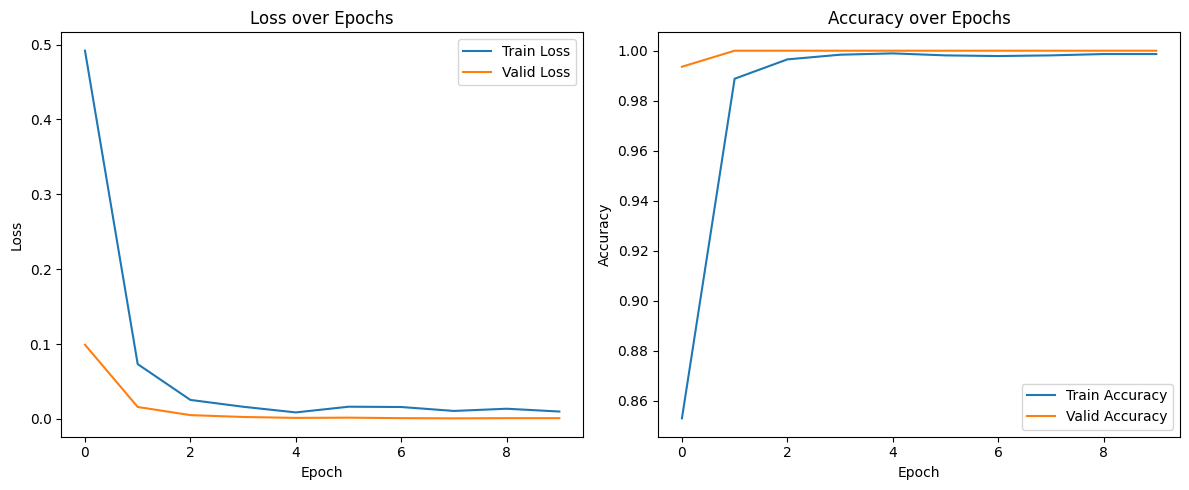


===== mobilenet_v2-partial_finetuning-PLAIN Test =====

Test Loss: 0.0013, Test Accuracy: 100.00%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "partial_finetuning"
    target_data_version = "plain"
    target_loader = train_plain_loader
    target_version = "002"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Partial FineTuning - Plain dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=PT_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


#### Full FineTuning - Plain

===== Training resnet50-full_finetuning-PLAIN =====
Epoch [1/5] train_loss: 0.2454 | train_acc: 92.87% | val_loss: 0.0101 | val_acc: 99.79%
Epoch [2/5] train_loss: 0.0219 | train_acc: 99.52% | val_loss: 0.0032 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0258 | train_acc: 99.81% | val_loss: 0.0007 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0146 | train_acc: 99.63% | val_loss: 0.0011 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0057 | train_acc: 99.87% | val_loss: 0.0005 | val_acc: 100.00%


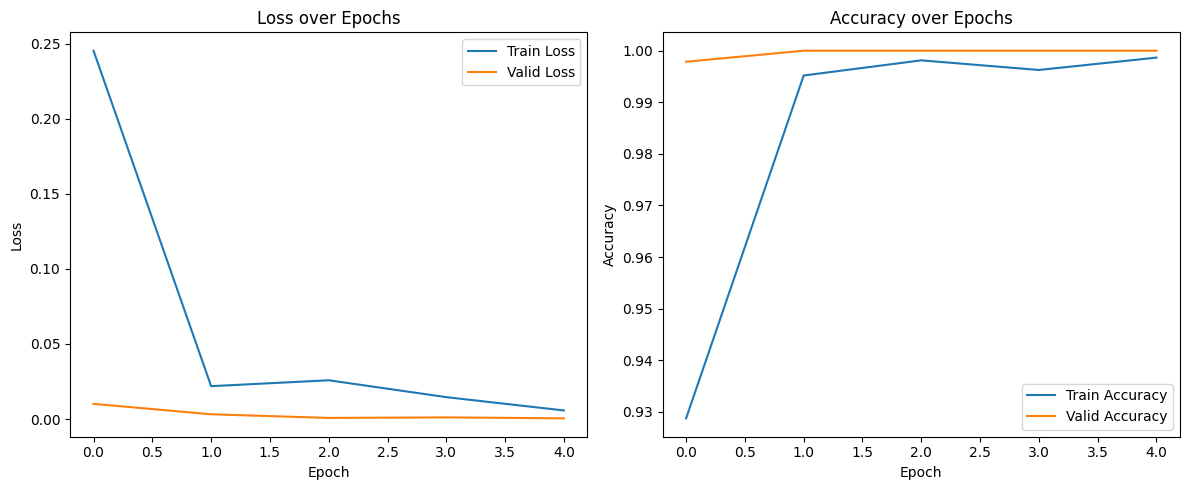


===== resnet50-full_finetuning-PLAIN Test =====

Test Loss: 0.0007, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training efficientnet_b2-full_finetuning-PLAIN =====
Epoch [1/5] train_loss: 0.3439 | train_acc: 90.07% | val_loss: 0.0208 | val_acc: 99.79%
Epoch [2/5] train_loss: 0.0361 | train_acc: 99.63% | val_loss: 0.0040 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0220 | train_acc: 99.73% | val_loss: 0.0014 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0158 | train_acc: 99.76% | val_loss: 0.0008 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0159 | train_acc: 99.79% | val_loss: 0.0008 | val_acc: 100.00%


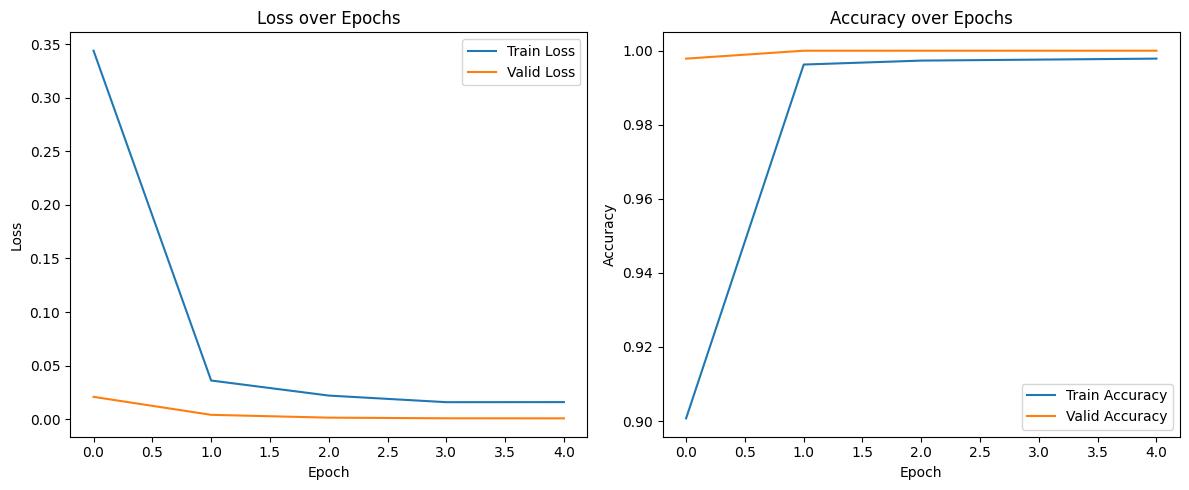


===== efficientnet_b2-full_finetuning-PLAIN Test =====

Test Loss: 0.0007, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training mobilenet_v2-full_finetuning-PLAIN =====
Epoch [1/5] train_loss: 0.3996 | train_acc: 89.67% | val_loss: 0.0464 | val_acc: 99.79%
Epoch [2/5] train_loss: 0.0340 | train_acc: 99.71% | val_loss: 0.0050 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0109 | train_acc: 99.97% | val_loss: 0.0019 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0097 | train_acc: 99.87% | val_loss: 0.0012 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0069 | train_acc: 99.87% | val_loss: 0.0010 | val_acc: 100.00%


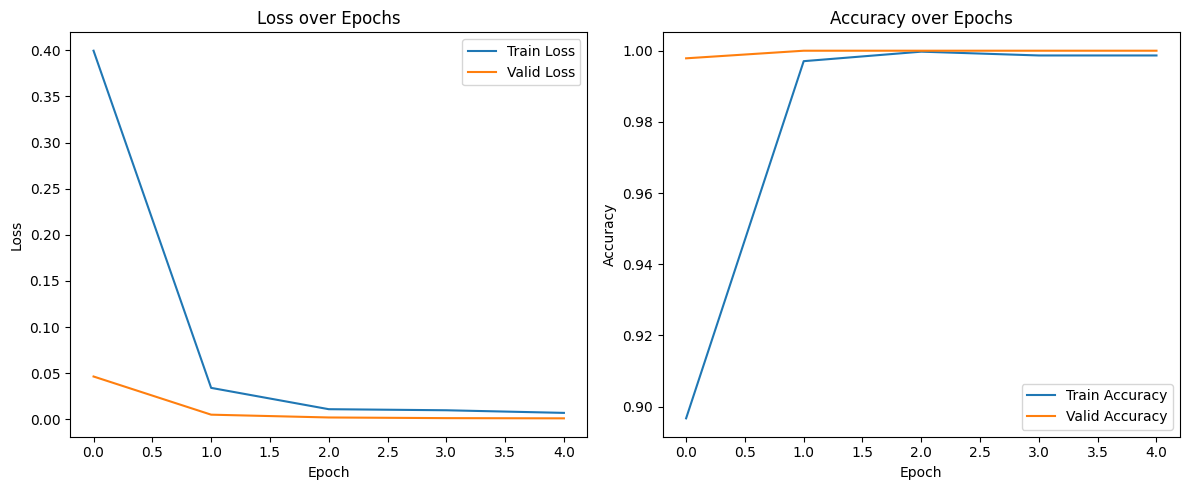


===== mobilenet_v2-full_finetuning-PLAIN Test =====

Test Loss: 0.0010, Test Accuracy: 100.00%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "full_finetuning"
    target_data_version = "plain"
    target_loader = train_plain_loader
    target_version = "002"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Full FineTuning - Plain dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=FT_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


#### Feature Extract - Augment

===== Training resnet50-feature_extract-AUG =====
Epoch [1/20] train_loss: 0.6071 | train_acc: 79.08% | val_loss: 0.4114 | val_acc: 87.18%
Epoch [2/20] train_loss: 0.3588 | train_acc: 89.30% | val_loss: 0.3212 | val_acc: 89.74%
Epoch [3/20] train_loss: 0.2725 | train_acc: 92.47% | val_loss: 0.2386 | val_acc: 94.23%
Epoch [4/20] train_loss: 0.2467 | train_acc: 93.65% | val_loss: 0.1979 | val_acc: 95.30%
Epoch [5/20] train_loss: 0.1978 | train_acc: 95.06% | val_loss: 0.1716 | val_acc: 96.58%
Epoch [6/20] train_loss: 0.1830 | train_acc: 95.62% | val_loss: 0.1529 | val_acc: 97.22%
Epoch [7/20] train_loss: 0.1771 | train_acc: 95.68% | val_loss: 0.1303 | val_acc: 98.50%
Epoch [8/20] train_loss: 0.1490 | train_acc: 96.24% | val_loss: 0.1353 | val_acc: 98.50%
Epoch [9/20] train_loss: 0.1390 | train_acc: 96.74% | val_loss: 0.1223 | val_acc: 97.44%
Epoch [10/20] train_loss: 0.1371 | train_acc: 96.74% | val_loss: 0.1402 | val_acc: 97.01%
Epoch [11/20] train_loss: 0.1273 | train_acc: 97.33% | val_

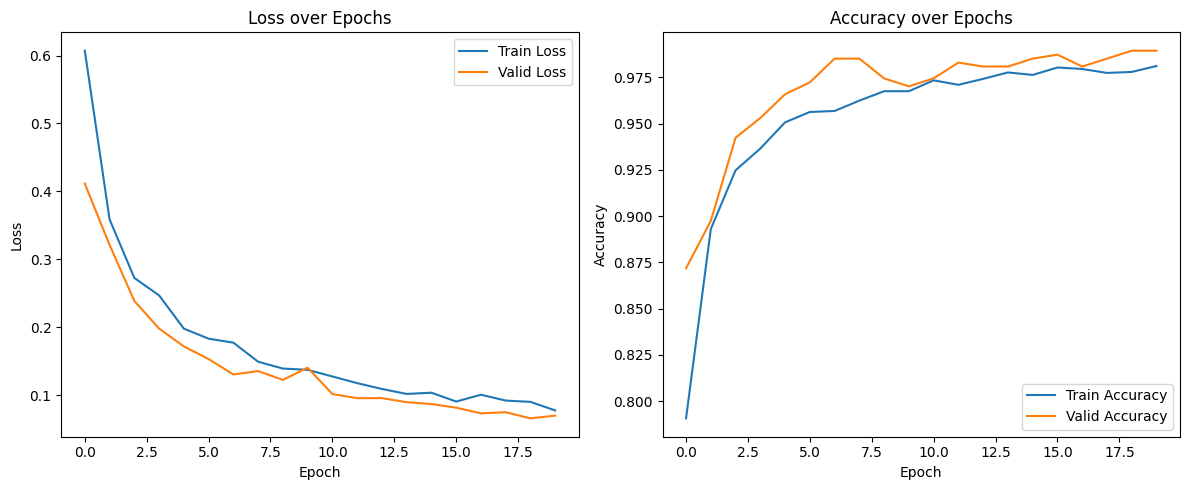


===== resnet50-feature_extract-AUG Test =====

Test Loss: 0.0761, Test Accuracy: 98.93%
Experiment log saved to DB.
===== Training efficientnet_b2-feature_extract-AUG =====
Epoch [1/20] train_loss: 0.6243 | train_acc: 77.64% | val_loss: 0.4192 | val_acc: 89.96%
Epoch [2/20] train_loss: 0.3884 | train_acc: 87.30% | val_loss: 0.3226 | val_acc: 91.03%
Epoch [3/20] train_loss: 0.3346 | train_acc: 88.50% | val_loss: 0.2740 | val_acc: 91.88%
Epoch [4/20] train_loss: 0.2891 | train_acc: 90.95% | val_loss: 0.2311 | val_acc: 94.23%
Epoch [5/20] train_loss: 0.2901 | train_acc: 90.15% | val_loss: 0.2189 | val_acc: 94.02%
Epoch [6/20] train_loss: 0.2662 | train_acc: 90.53% | val_loss: 0.2052 | val_acc: 94.23%
Epoch [7/20] train_loss: 0.2630 | train_acc: 89.81% | val_loss: 0.1965 | val_acc: 95.51%
Epoch [8/20] train_loss: 0.2613 | train_acc: 90.45% | val_loss: 0.1772 | val_acc: 94.44%
Epoch [9/20] train_loss: 0.2310 | train_acc: 91.11% | val_loss: 0.1907 | val_acc: 94.87%
Epoch [10/20] train_loss:

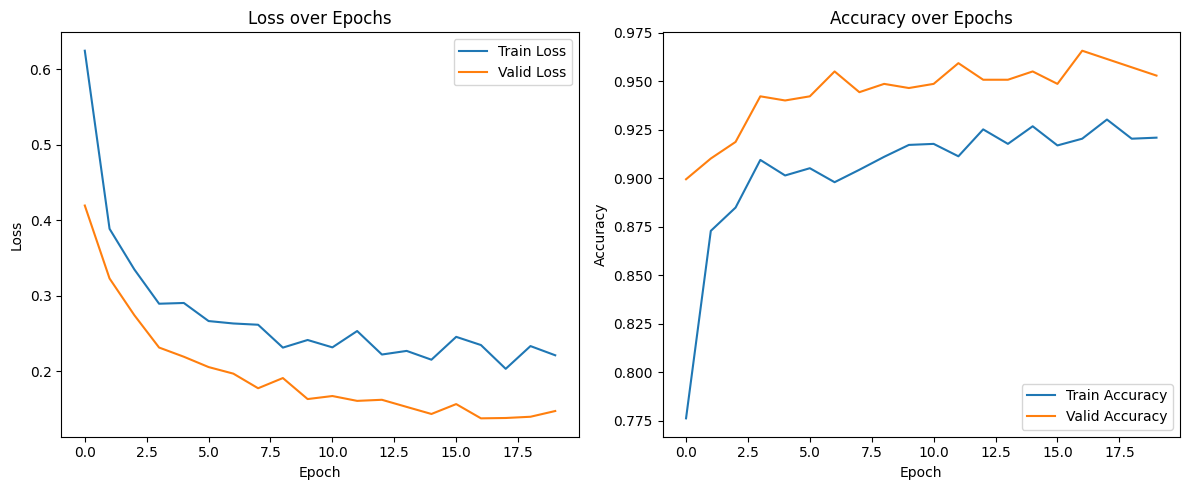


===== efficientnet_b2-feature_extract-AUG Test =====

Test Loss: 0.1456, Test Accuracy: 95.74%
Experiment log saved to DB.
===== Training mobilenet_v2-feature_extract-AUG =====
Epoch [1/20] train_loss: 0.6568 | train_acc: 76.33% | val_loss: 0.4694 | val_acc: 84.83%
Epoch [2/20] train_loss: 0.4290 | train_acc: 85.05% | val_loss: 0.3628 | val_acc: 89.53%
Epoch [3/20] train_loss: 0.3497 | train_acc: 88.79% | val_loss: 0.3200 | val_acc: 89.74%
Epoch [4/20] train_loss: 0.3244 | train_acc: 89.56% | val_loss: 0.2726 | val_acc: 92.09%
Epoch [5/20] train_loss: 0.2958 | train_acc: 89.99% | val_loss: 0.2576 | val_acc: 92.31%
Epoch [6/20] train_loss: 0.2759 | train_acc: 90.85% | val_loss: 0.2480 | val_acc: 91.67%
Epoch [7/20] train_loss: 0.2563 | train_acc: 91.70% | val_loss: 0.2217 | val_acc: 93.59%
Epoch [8/20] train_loss: 0.2357 | train_acc: 92.26% | val_loss: 0.2297 | val_acc: 93.38%
Epoch [9/20] train_loss: 0.2299 | train_acc: 92.21% | val_loss: 0.2425 | val_acc: 90.38%
Epoch [10/20] train_l

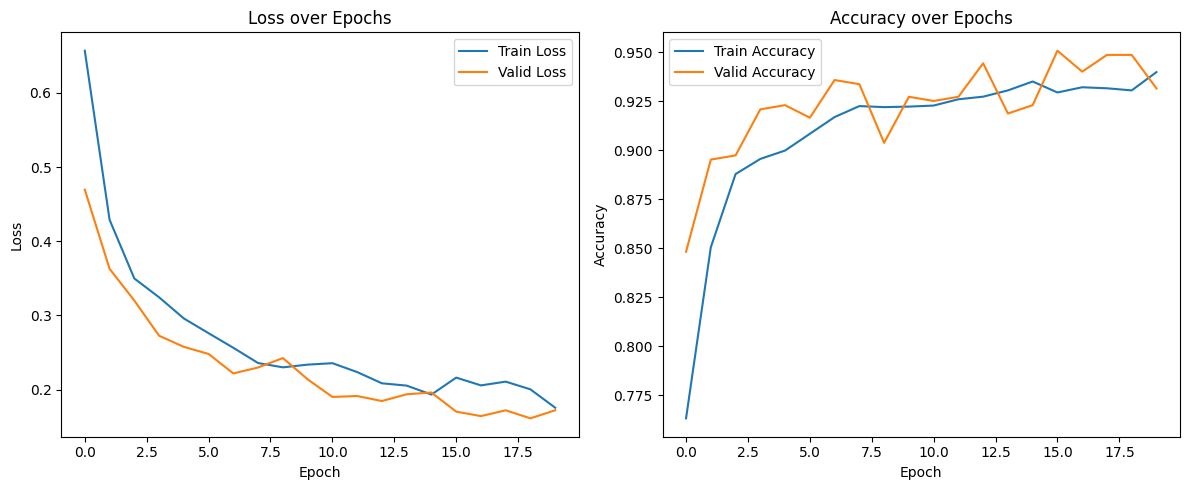


===== mobilenet_v2-feature_extract-AUG Test =====

Test Loss: 0.1850, Test Accuracy: 93.18%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "feature_extract"
    target_data_version = "aug"
    target_loader = train_aug_loader
    target_version = "003"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Feature Extract - Augment dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=FE_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


#### Partial FineTuning - Augment

===== Training resnet50-partial_finetuning-AUG =====
Epoch [1/10] train_loss: 0.3561 | train_acc: 88.76% | val_loss: 0.0533 | val_acc: 99.36%
Epoch [2/10] train_loss: 0.0386 | train_acc: 99.07% | val_loss: 0.0182 | val_acc: 100.00%
Epoch [3/10] train_loss: 0.0228 | train_acc: 99.60% | val_loss: 0.0085 | val_acc: 99.79%
Epoch [4/10] train_loss: 0.0128 | train_acc: 99.76% | val_loss: 0.0051 | val_acc: 100.00%
Epoch [5/10] train_loss: 0.0119 | train_acc: 99.84% | val_loss: 0.0011 | val_acc: 100.00%
Epoch [6/10] train_loss: 0.0162 | train_acc: 99.65% | val_loss: 0.0025 | val_acc: 100.00%
Epoch [7/10] train_loss: 0.0133 | train_acc: 99.71% | val_loss: 0.0015 | val_acc: 100.00%
Epoch [8/10] train_loss: 0.0121 | train_acc: 99.76% | val_loss: 0.0016 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0107 | train_acc: 99.76% | val_loss: 0.0020 | val_acc: 100.00%
Epoch [10/10] train_loss: 0.0068 | train_acc: 99.92% | val_loss: 0.0032 | val_acc: 99.79%


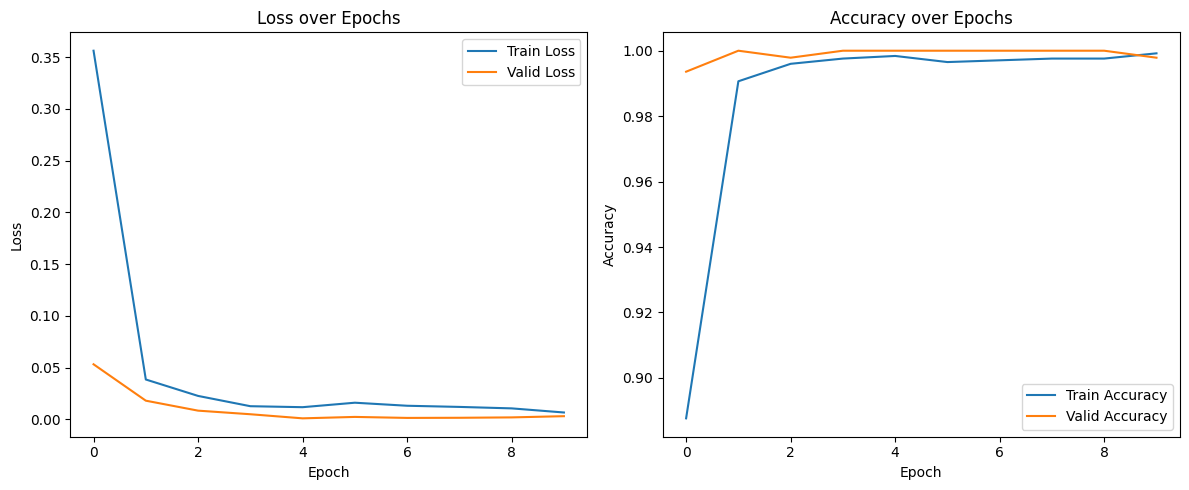


===== resnet50-partial_finetuning-AUG Test =====

Test Loss: 0.0028, Test Accuracy: 99.79%
Experiment log saved to DB.
===== Training efficientnet_b2-partial_finetuning-AUG =====
Epoch [1/10] train_loss: 0.4284 | train_acc: 86.31% | val_loss: 0.0794 | val_acc: 98.93%
Epoch [2/10] train_loss: 0.0814 | train_acc: 98.13% | val_loss: 0.0161 | val_acc: 100.00%
Epoch [3/10] train_loss: 0.0298 | train_acc: 99.33% | val_loss: 0.0070 | val_acc: 100.00%
Epoch [4/10] train_loss: 0.0276 | train_acc: 99.44% | val_loss: 0.0070 | val_acc: 99.79%
Epoch [5/10] train_loss: 0.0247 | train_acc: 99.31% | val_loss: 0.0040 | val_acc: 100.00%
Epoch [6/10] train_loss: 0.0231 | train_acc: 99.52% | val_loss: 0.0034 | val_acc: 100.00%
Epoch [7/10] train_loss: 0.0223 | train_acc: 99.63% | val_loss: 0.0023 | val_acc: 100.00%
Epoch [8/10] train_loss: 0.0148 | train_acc: 99.65% | val_loss: 0.0032 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0170 | train_acc: 99.84% | val_loss: 0.0013 | val_acc: 100.00%
Epoch [10/10

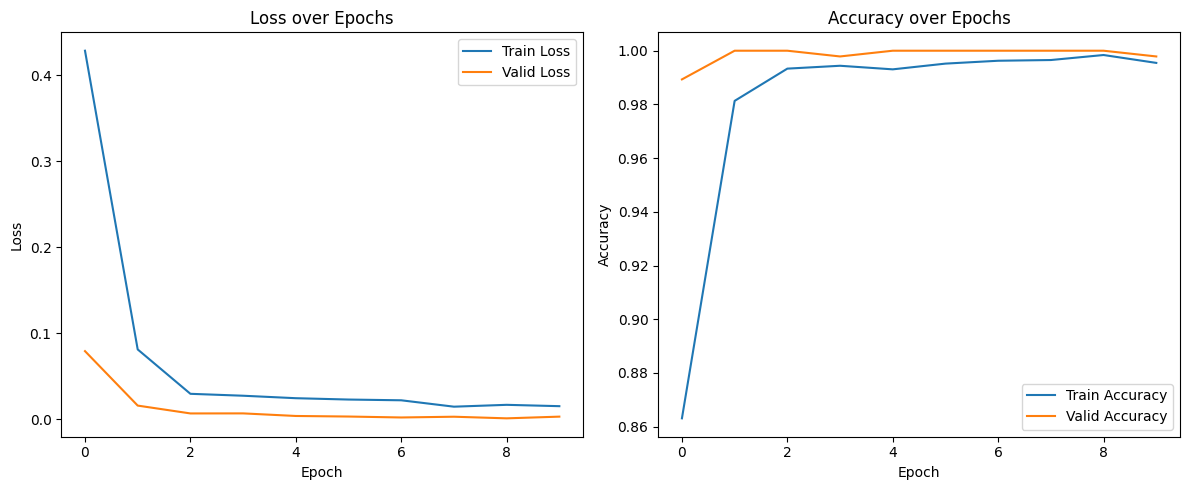


===== efficientnet_b2-partial_finetuning-AUG Test =====

Test Loss: 0.0006, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training mobilenet_v2-partial_finetuning-AUG =====
Epoch [1/10] train_loss: 0.5774 | train_acc: 80.41% | val_loss: 0.2100 | val_acc: 95.09%
Epoch [2/10] train_loss: 0.1569 | train_acc: 96.34% | val_loss: 0.0692 | val_acc: 99.15%
Epoch [3/10] train_loss: 0.0611 | train_acc: 98.59% | val_loss: 0.0380 | val_acc: 99.57%
Epoch [4/10] train_loss: 0.0494 | train_acc: 98.85% | val_loss: 0.0212 | val_acc: 100.00%
Epoch [5/10] train_loss: 0.0349 | train_acc: 99.12% | val_loss: 0.0131 | val_acc: 99.79%
Epoch [6/10] train_loss: 0.0200 | train_acc: 99.68% | val_loss: 0.0071 | val_acc: 100.00%
Epoch [7/10] train_loss: 0.0204 | train_acc: 99.73% | val_loss: 0.0084 | val_acc: 99.79%
Epoch [8/10] train_loss: 0.0195 | train_acc: 99.49% | val_loss: 0.0082 | val_acc: 100.00%
Epoch [9/10] train_loss: 0.0119 | train_acc: 99.73% | val_loss: 0.0054 | val_acc: 100.00%
Epoch [10/

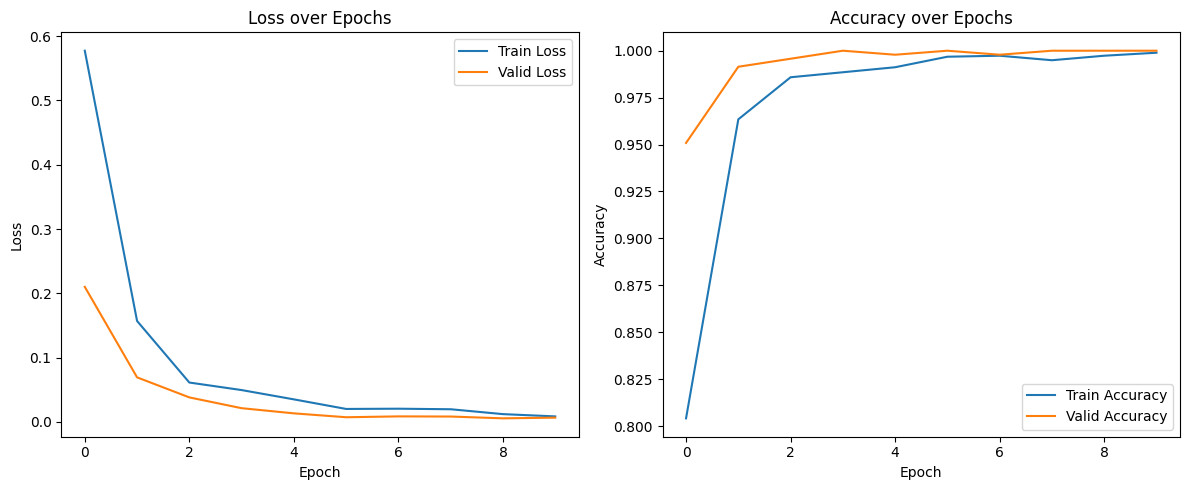


===== mobilenet_v2-partial_finetuning-AUG Test =====

Test Loss: 0.0050, Test Accuracy: 100.00%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "partial_finetuning"
    target_data_version = "aug"
    target_loader = train_aug_loader
    target_version = "002"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Partial FineTuning - Augment dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=PT_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


#### Full FineTuning - Augment

===== Training resnet50-full_finetuning-AUG =====
Epoch [1/5] train_loss: 0.2713 | train_acc: 91.59% | val_loss: 0.0076 | val_acc: 100.00%
Epoch [2/5] train_loss: 0.0224 | train_acc: 99.49% | val_loss: 0.0014 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0246 | train_acc: 99.55% | val_loss: 0.0037 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0245 | train_acc: 99.33% | val_loss: 0.0027 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0165 | train_acc: 99.55% | val_loss: 0.0036 | val_acc: 99.79%


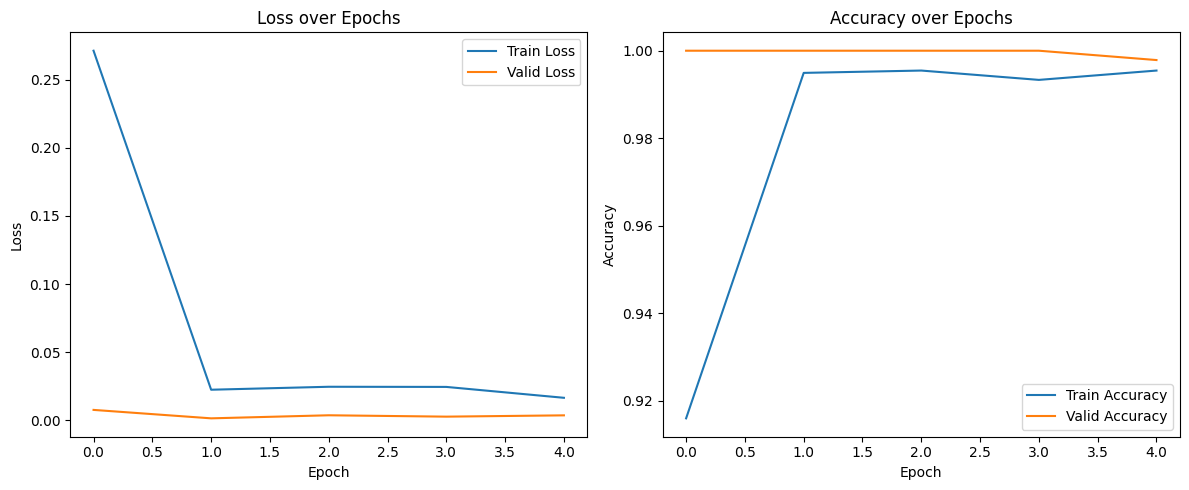


===== resnet50-full_finetuning-AUG Test =====

Test Loss: 0.0040, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training efficientnet_b2-full_finetuning-AUG =====
Epoch [1/5] train_loss: 0.3894 | train_acc: 87.00% | val_loss: 0.0371 | val_acc: 100.00%
Epoch [2/5] train_loss: 0.0506 | train_acc: 99.49% | val_loss: 0.0053 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0131 | train_acc: 99.89% | val_loss: 0.0025 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0185 | train_acc: 99.73% | val_loss: 0.0012 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0131 | train_acc: 99.79% | val_loss: 0.0054 | val_acc: 99.79%


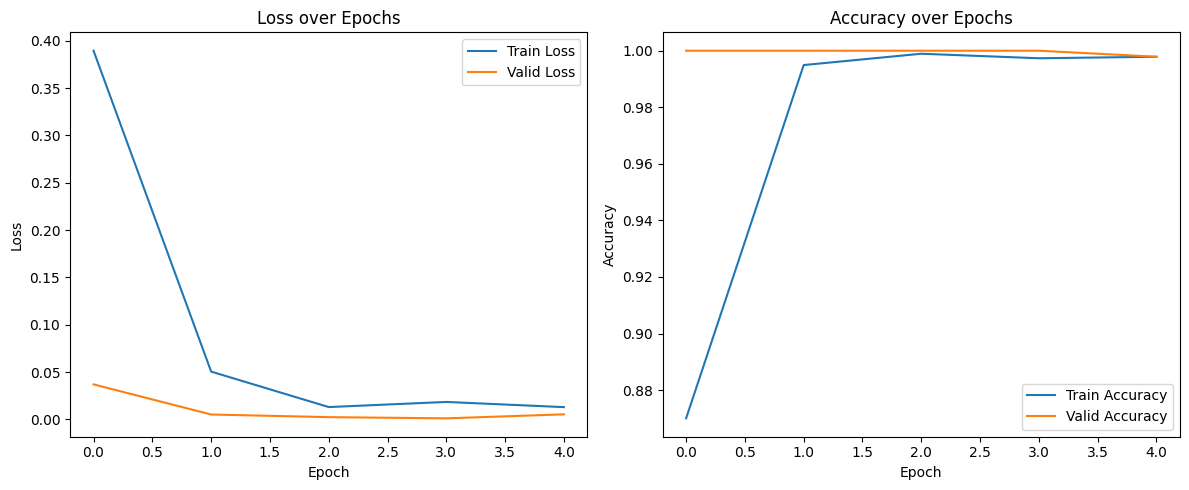


===== efficientnet_b2-full_finetuning-AUG Test =====

Test Loss: 0.0016, Test Accuracy: 100.00%
Experiment log saved to DB.
===== Training mobilenet_v2-full_finetuning-AUG =====
Epoch [1/5] train_loss: 0.5213 | train_acc: 82.04% | val_loss: 0.1370 | val_acc: 97.44%
Epoch [2/5] train_loss: 0.0829 | train_acc: 97.86% | val_loss: 0.0233 | val_acc: 100.00%
Epoch [3/5] train_loss: 0.0298 | train_acc: 99.39% | val_loss: 0.0092 | val_acc: 100.00%
Epoch [4/5] train_loss: 0.0154 | train_acc: 99.71% | val_loss: 0.0040 | val_acc: 100.00%
Epoch [5/5] train_loss: 0.0084 | train_acc: 99.89% | val_loss: 0.0029 | val_acc: 100.00%


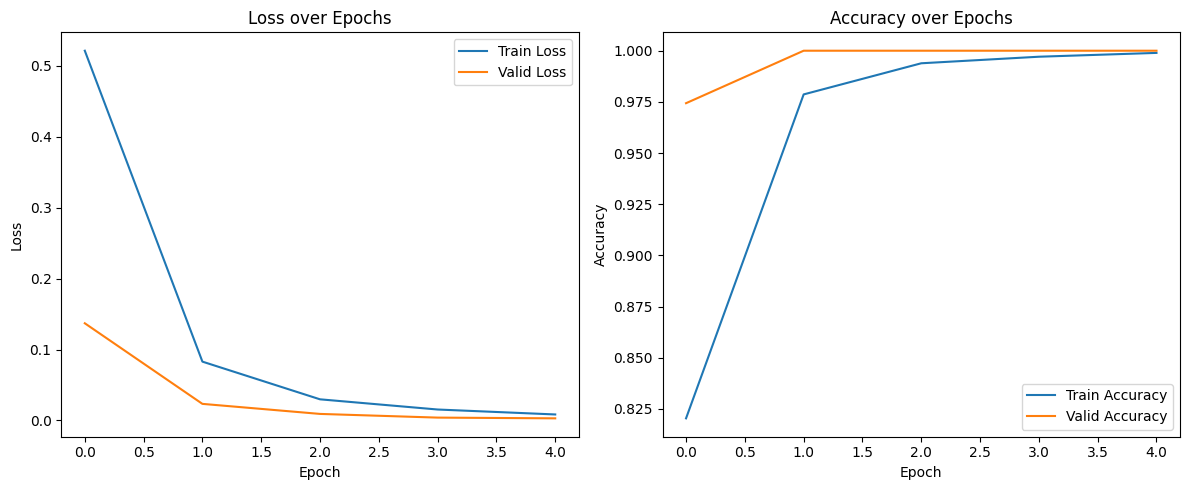


===== mobilenet_v2-full_finetuning-AUG Test =====

Test Loss: 0.0056, Test Accuracy: 100.00%
Experiment log saved to DB.


In [ ]:
for key, (model, optimizer) in models_dict.items():
    model_name, tuning_mode, data_version = key.split("-")

    target_mode = "full_finetuning"
    target_data_version = "aug"
    target_loader = train_aug_loader
    target_version = "002"

    if tuning_mode == target_mode and data_version == target_data_version:
        note = "Ful FineTuning - Augment dataset"
        desc = f"{model_name}-{tuning_mode}-{data_version.upper()}"

        run_experiment(
            model=model,
            train_loader=target_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=FT_NUM_EPOCHS,
            model_name=model_name,
            tuning_type=tuning_mode,
            data_type=target_data_version,
            version=target_version,
            desc=desc,
            note=note
        )


### 결과 확인

In [ ]:
def get_gradcam_target_layer(model):
    """
    모델의 구조에 따라 Grad-CAM에 사용할 target layer를 반환합니다.
    - ResNet 계열: model.layer4[-1]
    - EfficientNet/MobileNet 계열: model.features[-1]
    """
    if hasattr(model, "layer4"):
        return model.layer4[-1]
    elif hasattr(model, "features"):
        return model.features[-1]
    else:
        raise ValueError("Grad-CAM 지원을 위한 적절한 target layer를 찾을 수 없습니다.")

In [ ]:
import os
import matplotlib.pyplot as plt

def save_gradcam_plot(model_name, tuning_type, data_type, version, original_img, gradcam_img):
    """
    Grad-CAM과 원본 이미지를 비교하는 플롯을 저장합니다.
    파일명은 모델명, 튜닝 방식, 버전 정보를 포함합니다.
    저장 경로: "/content/drive/MyDrive/Code/ktb/assignment/8th/grad-cam"
    """
    # 비교 플롯 생성
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img)
    ax[0].set_title("Original")
    ax[1].imshow(gradcam_img)
    ax[1].set_title("Grad-CAM")
    plt.tight_layout()

    # 저장 경로 확인 및 생성
    save_dir = "/content/drive/MyDrive/Code/ktb/assignment/8th/grad-cam"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 파일명: 예) rn50_partial_finetuning_v1.png
    filename = f"{model_name}-{tuning_type}-{data_type}-{version}.png"
    save_path = os.path.join(save_dir, filename)

    plt.savefig(save_path)
    plt.close(fig)
    print(f"Grad-CAM plot saved to {save_path}")


불러올 모델 가중치 파일: /content/drive/MyDrive/Code/ktb/assignment/8th/model_weights/efficientnet_b0-partial_finetuning-aug-001.pth

Test Loss: 0.0147, Test Accuracy: 99.79%
Retest 결과 - Test Loss: 0.0147, Test Accuracy: 99.79%


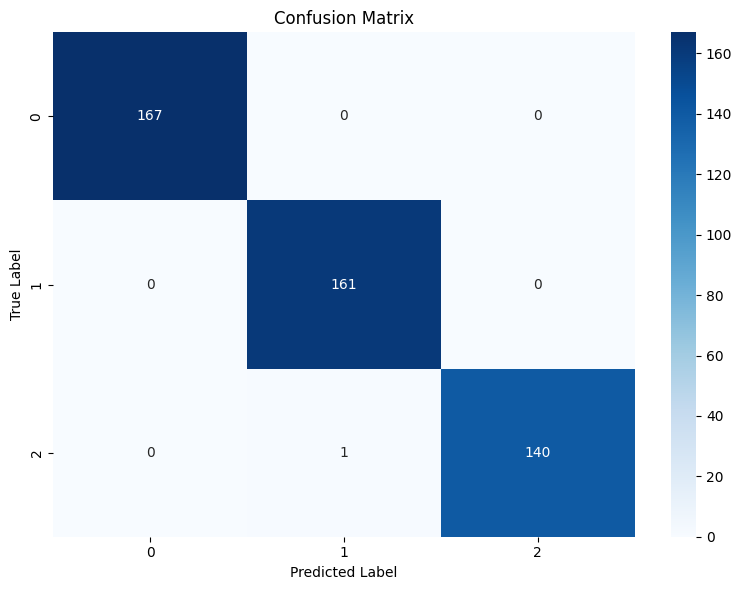

In [ ]:
# model_names = ["resnet50", "efficientnet_b0", "mobilenet_v2"]
# tuning_modes = ["feature_extract", "partial_finetuning"]
# data_versions = ["plain", "aug"]

conn = sqlite3.connect(db_path)
c = conn.cursor()
query = """
    SELECT pth_path
    FROM experiment_log
    WHERE model_name = ? AND tuning_type = ?
    AND data_type = ? AND version = ?
    ORDER BY timestamp DESC
    LIMIT 1
"""
target_model_name = "efficientnet_b0"
target_tuning_type = "partial_finetuning"
target_data_type = "aug"
target_version = "001"
c.execute(query, (target_model_name, target_tuning_type, target_data_type, target_version))
result = c.fetchone()
conn.close()

if result is None:
    print("모델에 해당하는 로그가 DB에 없습니다.")
else:
    pth_path = result[0]
    print("불러올 모델 가중치 파일:", pth_path)

    # 모델 로드
    model, _ = get_model(
        name=target_model_name,
        num_classes=3,
        mode=target_tuning_type)
    model.load_state_dict(torch.load(pth_path))
    model.to(device)

    test_loss, test_acc, all_preds, all_labels = test_model(model, loss_fn)
    print(f"Retest 결과 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

    show_confusion_matrix(all_preds, all_labels)

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# "결과 확인" 파트: 테스트 이미지와 Grad-CAM 결과를 나란히 비교
model.eval()  # 모델을 평가 모드로 전환

# test_loader에서 10개 이미지 선택 (배치 사이즈가 10 이상이어야 합니다)
num_images = 32
batch = next(iter(test_loader))
images, labels = batch  # images: [B, C, H, W]
images = images[:num_images].to(device)

# Grad-CAM 대상 layer 선택 (get_gradcam_target_layer 함수가 정의되어 있어야 합니다)
target_layer = get_gradcam_target_layer(model)
print("Grad-CAM target layer:", target_layer)

for param in target_layer.parameters(): # target_layer Unfreeze
    param.requires_grad = True

# Grad-CAM 객체 생성 (GPU 사용 여부에 따라 use_cuda 설정)
cam_extractor = GradCAM(model=model, target_layers=[target_layer])
# 원본 이미지와 Grad-CAM 결과 저장 리스트
original_images = []
gradcam_images = []

# 각 이미지에 대해 Grad-CAM 계산 및 결과 생성
for i in range(num_images):
    input_tensor = images[i].unsqueeze(0)  # [1, C, H, W]

    # Grad-CAM 계산 (target_category=None이면 모델이 예측한 최고 점수 클래스를 사용)
    grayscale_cam = cam_extractor(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]  # [H, W]

    # de-normalize: plain_transform 기준 normalization 복원
    img_np = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean  # 원본 이미지 복원
    img_np = np.clip(img_np, 0, 1)

    # Grad-CAM 오버레이 생성 (원본 이미지와 heatmap을 결합)
    gradcam_overlay = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    original_images.append(img_np)
    gradcam_images.append(gradcam_overlay)

# 결과를 2열로 나란히 출력: 왼쪽은 원본, 오른쪽은 Grad-CAM
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
for i in range(num_images):
    axes[i, 0].imshow(original_images[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(gradcam_images[i])
    axes[i, 1].set_title("Grad-CAM")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 로그 처리

In [ ]:
import sqlite3

def delete_log_by_id(db_path, log_id):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()

    # id 값을 기준으로 삭제
    c.execute("DELETE FROM experiment_log WHERE id = ?", (log_id,))

    conn.commit()
    conn.close()

    print(f"Log with id {log_id} has been deleted.")


In [ ]:
delete_log_by_id(db_path, 21)

Log with id 21 has been deleted.
